# 03: Advanced Models - Word2Vec and BERT

This notebook trains and evaluates advanced NLP models for genre classification.

**Models trained:**
1. **Word2Vec + Logistic Regression** - Semantic word embeddings
2. **BERT/DistilBERT** - Transformer-based contextual understanding

**Why these models?**
- **Word2Vec:** Captures semantic similarity between words
- **BERT:** State-of-the-art contextual language model
- Compare with TF-IDF baseline to see if semantic/contextual understanding helps

**Hardware Requirements:**
- Word2Vec: CPU (2-3 minutes)
- BERT: GPU recommended (50+ minutes on 8x A16 GPUs)

**Outputs:**
- Model performance metrics
- Confusion matrices
- Training curves for BERT
- Results saved to `experiments/results/`

## Setup

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import our modules
from src.data_loader import load_and_prepare_data
from src.models import Word2VecModel, BERTModel
from src.evaluate import (
    evaluate_model, 
    plot_confusion_matrix, 
    plot_per_genre_metrics
)
from src.utils import set_seed, get_device, get_gpu_info, GENRES

# Set random seed for reproducibility
set_seed(42)

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete!")

/home/jovyan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✅ Random seed set to 42
✓ Setup complete!


### Check GPU Availability

In [2]:
# Check device and GPU info
device = get_device()
print(f"Using device: {device}")

if 'cuda' in str(device):
    gpu_info = get_gpu_info()
    print(f"\nGPU Information:")
    for key, value in gpu_info.items():
        print(f"  {key}: {value}")
else:
    print("\n⚠️  No GPU detected. BERT training will be very slow on CPU.")
    print("   Consider reducing samples_per_genre or using a GPU instance.")

Using device: cuda

GPU Information:
  cuda_available: True
  device_count: 8
  devices: [{'id': 0, 'name': 'NVIDIA A16', 'memory_total': 15.728836608}, {'id': 1, 'name': 'NVIDIA A16', 'memory_total': 15.728836608}, {'id': 2, 'name': 'NVIDIA A16', 'memory_total': 15.728836608}, {'id': 3, 'name': 'NVIDIA A16', 'memory_total': 15.728836608}, {'id': 4, 'name': 'NVIDIA A16', 'memory_total': 15.728836608}, {'id': 5, 'name': 'NVIDIA A16', 'memory_total': 15.728836608}, {'id': 6, 'name': 'NVIDIA A16', 'memory_total': 15.728836608}, {'id': 7, 'name': 'NVIDIA A16', 'memory_total': 15.728836608}]


## 1. Load Preprocessed Data

**Important:** BERT training is computationally expensive.
- **Quick testing (CPU/single GPU):** 5,000 samples/genre
- **Standard (multi-GPU):** 20,000 samples/genre
- **Full (multi-GPU):** 50,000+ samples/genre

In [3]:
# Configuration
SAMPLES_PER_GENRE = 20000  # Adjust based on your hardware
TEST_SIZE = 0.2

print(f"Loading data with {SAMPLES_PER_GENRE:,} samples per genre...\n")

# Load and split data
X_train, X_test, y_train, y_test = load_and_prepare_data(
    samples_per_genre=SAMPLES_PER_GENRE,
    test_size=TEST_SIZE,
    use_cached=True,
    random_state=42
)

print(f"\n✓ Data loaded successfully!")
print(f"  Training set: {len(X_train):,} samples")
print(f"  Test set: {len(X_test):,} samples")

Loading data with 20,000 samples per genre...

✅ Random seed set to 42
Loading cached balanced dataset from /home/jovyan/Desktop/NLP/Project/data/song_lyrics_balanced.csv

Balancing dataset to 20,000 samples per genre...
  country: 20,000
  pop: 20,000
  rap: 20,000
  rb: 20,000
  rock: 20,000

✅ Balanced dataset: 100,000 songs

✅ Train/Test split:
   Training: 80,000 samples
   Test: 20,000 samples

✓ Data loaded successfully!
  Training set: 80,000 samples
  Test set: 20,000 samples


## 2. Model 1: Word2Vec + Logistic Regression

Word2Vec learns semantic word embeddings from the corpus.

**Approach:**
1. Train Word2Vec on all lyrics to learn word vectors
2. Represent each song as the average of its word vectors
3. Train Logistic Regression on these representations

**Hypothesis:** Semantic similarity might help (e.g., "love" in pop vs rap)
**Reality:** Genre classification is often more keyword-based than semantic

In [4]:
# Train Word2Vec model
print("Training Word2Vec + Logistic Regression...\n")

start_time = time.time()

model_w2v = Word2VecModel(
    classifier_type='logistic',
    vector_size=200,
    window=5,
    min_count=5,
    epochs=10
)

model_w2v.fit(X_train, y_train)

train_time_w2v = time.time() - start_time
print(f"\n⏱️  Training time: {train_time_w2v:.2f} seconds ({train_time_w2v/60:.1f} minutes)")

Training Word2Vec + Logistic Regression...

Training Word2Vec + logistic...
  Word2Vec vocabulary: 150,386 words
✅ Training complete

⏱️  Training time: 52.15 seconds (0.9 minutes)


### Evaluate Word2Vec

In [5]:
# Make predictions
y_pred_w2v = model_w2v.predict(X_test)

# Evaluate
results_w2v = evaluate_model(y_test, y_pred_w2v, model_name="Word2Vec + Logistic Regression")

print(f"\n{'='*80}")
print(f"WORD2VEC + LOGISTIC REGRESSION RESULTS")
print(f"{'='*80}")
print(f"Accuracy: {results_w2v['accuracy']:.4f}")
print(f"Macro F1: {results_w2v['macro_avg']['f1']:.4f}")
print(f"Weighted F1: {results_w2v['weighted_avg']['f1']:.4f}")
print(f"Training time: {train_time_w2v:.2f}s")
print(f"{'='*80}")

WORD2VEC + LOGISTIC REGRESSION EVALUATION RESULTS

Overall Accuracy: 0.2000

Per-Genre Performance:
Genre        Precision    Recall       F1-Score     Support
----------------------------------------------------------------------
country      0.2000       1.0000       0.3333       4000
pop          0.0000       0.0000       0.0000       4000
rap          0.0000       0.0000       0.0000       4000
rb           0.0000       0.0000       0.0000       4000
rock         0.0000       0.0000       0.0000       4000

WORD2VEC + LOGISTIC REGRESSION RESULTS
Accuracy: 0.2000
Macro F1: 0.0667
Weighted F1: 0.0667
Training time: 52.15s


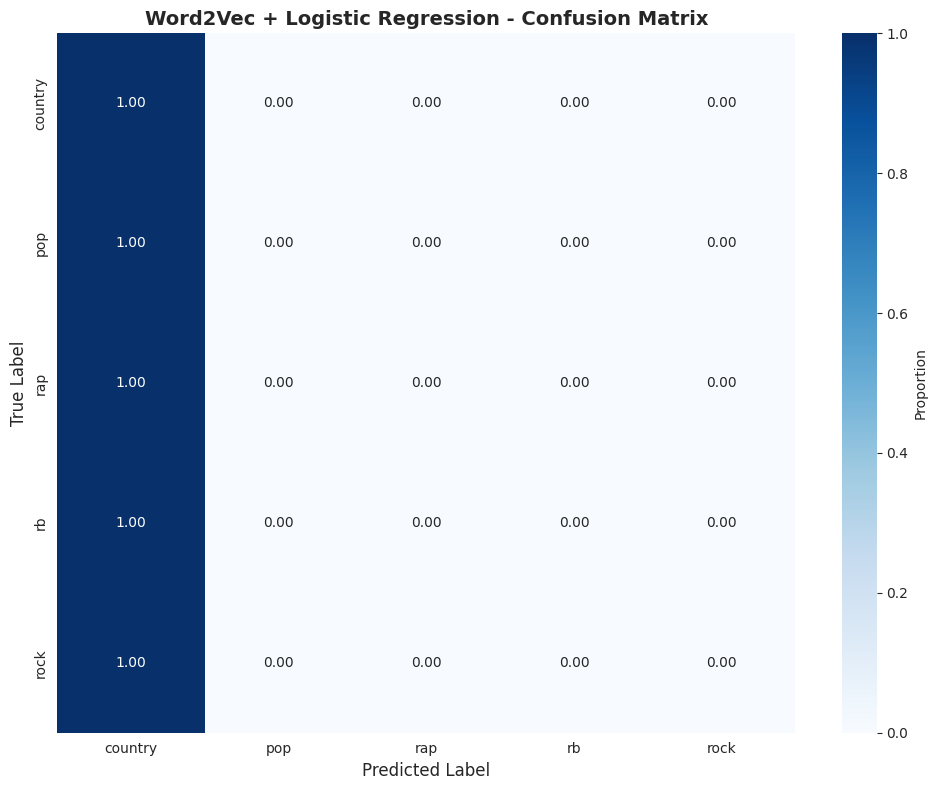

In [6]:
# Confusion matrix
plot_confusion_matrix(
    y_test, 
    y_pred_w2v,
    title="Word2Vec + Logistic Regression - Confusion Matrix",
    normalize=True
)

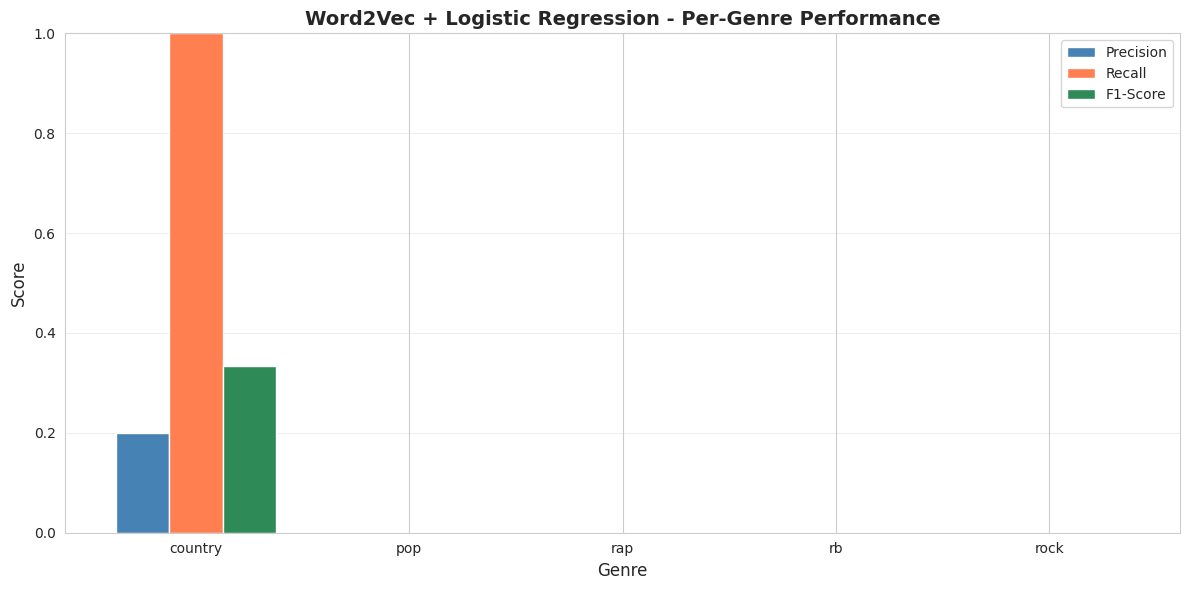

In [7]:
# Per-genre performance
plot_per_genre_metrics(
    results_w2v,
    title="Word2Vec + Logistic Regression - Per-Genre Performance"
)

### Word2Vec Semantic Exploration (Optional)

Let's explore what the Word2Vec model learned.

In [8]:
# Explore similar words
test_words = ['love', 'rap', 'guitar', 'party', 'heart', 'money']

print("Word2Vec Semantic Similarities:\n")
print("="*80)

for word in test_words:
    if word in model_w2v.w2v_model.wv:
        similar = model_w2v.w2v_model.wv.most_similar(word, topn=5)
        print(f"\n'{word}' is similar to:")
        for similar_word, score in similar:
            print(f"  {similar_word}: {score:.3f}")
    else:
        print(f"\n'{word}' not in vocabulary")

Word2Vec Semantic Similarities:


'love' is similar to:
  terrasse: 0.299
  abbracciati: 0.289
  temat,: 0.282
  jutra: 0.279
  lamb': 0.277

'rap' is similar to:
  pa'lante,: 0.327
  fatale: 0.289
  vaco: 0.272
  tarjetas: 0.271
  llueva: 0.271

'guitar' is similar to:
  никакой: 0.322
  duérmase: 0.290
  alen',: 0.287
  quemar: 0.277
  wunder: 0.277

'party' is similar to:
  bloody: 0.305
  lanes): 0.275
  следы: 0.270
  ensinou: 0.264
  tightens: 0.262

'heart' is similar to:
  wildest: 0.312
  released: 0.306
  tanhai: 0.298
  gieok: 0.293
  v.i.p.: 0.292

'money' is similar to:
  cheer: 0.292
  aldrei: 0.289
  mayhem: 0.288
  "please,: 0.277
  clothin': 0.273


## 3. Model 2: BERT/DistilBERT

Fine-tune a pre-trained transformer model for genre classification.

**Model:** DistilBERT (multilingual)
- Faster than BERT (40% smaller, 60% faster)
- Multilingual support (dataset contains some non-English lyrics)
- Strong performance on text classification

**Training configuration:**
- Max sequence length: 256 tokens (optimal speed/performance tradeoff)
- Batch size: 96 (distributed across GPUs)
- Learning rate: 2e-5 with warmup
- Mixed precision (FP16) for speed

**⚠️ Warning:** This will take 30-60 minutes even with multiple GPUs!

In [9]:
# BERT configuration
bert_config = {
    'model_name': 'distilbert-base-multilingual-cased',
    'max_length': 256,
    'batch_size': 96,  # Total across all GPUs
    'learning_rate': 2e-5,
    'epochs': 5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.1,  # Regularization to prevent overfitting
    'use_amp': True  # Mixed precision for speed
}

print("BERT Configuration:")
for key, value in bert_config.items():
    print(f"  {key}: {value}")

BERT Configuration:
  model_name: distilbert-base-multilingual-cased
  max_length: 256
  batch_size: 96
  learning_rate: 2e-05
  epochs: 5
  warmup_ratio: 0.1
  weight_decay: 0.1
  use_amp: True


In [10]:
# Train BERT model
print("\nTraining BERT model...")
print("This may take 30-60 minutes depending on your hardware.\n")

start_time = time.time()

model_bert = BERTModel(**bert_config)
model_bert.fit(X_train, y_train)

train_time_bert = time.time() - start_time
print(f"\n⏱️  Training time: {train_time_bert:.2f} seconds ({train_time_bert/60:.1f} minutes)")


Training BERT model...
This may take 30-60 minutes depending on your hardware.

Initializing distilbert-base-multilingual-cased
  Device: cuda


2025-10-18 23:51:38.280895: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 23:51:40.304684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 23:51:44.044791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight

  Using 8 GPUs
  Parameters: 135,328,517

Training distilbert-base-multilingual-cased...


/home/jovyan/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  Epoch 1/5: loss = 1.1463
  Epoch 2/5: loss = 0.9229
  Epoch 3/5: loss = 0.8346
  Epoch 4/5: loss = 0.7554
  Epoch 5/5: loss = 0.6914
✅ Training complete

⏱️  Training time: 7073.53 seconds (117.9 minutes)


### Evaluate BERT

In [11]:
# Make predictions
print("Making predictions on test set...\n")
y_pred_bert = model_bert.predict(X_test)

# Evaluate
results_bert = evaluate_model(y_test, y_pred_bert, model_name="DistilBERT")

print(f"\n{'='*80}")
print(f"DISTILBERT RESULTS")
print(f"{'='*80}")
print(f"Accuracy: {results_bert['accuracy']:.4f}")
print(f"Macro F1: {results_bert['macro_avg']['f1']:.4f}")
print(f"Weighted F1: {results_bert['weighted_avg']['f1']:.4f}")
print(f"Training time: {train_time_bert:.2f}s ({train_time_bert/60:.1f} min)")
print(f"{'='*80}")

Making predictions on test set...

DISTILBERT EVALUATION RESULTS

Overall Accuracy: 0.6280

Per-Genre Performance:
Genre        Precision    Recall       F1-Score     Support
----------------------------------------------------------------------
country      0.6887       0.7432       0.7149       4000
pop          0.4747       0.3663       0.4135       4000
rap          0.8102       0.7833       0.7965       4000
rb           0.6144       0.6122       0.6133       4000
rock         0.5352       0.6348       0.5807       4000

DISTILBERT RESULTS
Accuracy: 0.6280
Macro F1: 0.6238
Weighted F1: 0.6238
Training time: 7073.53s (117.9 min)


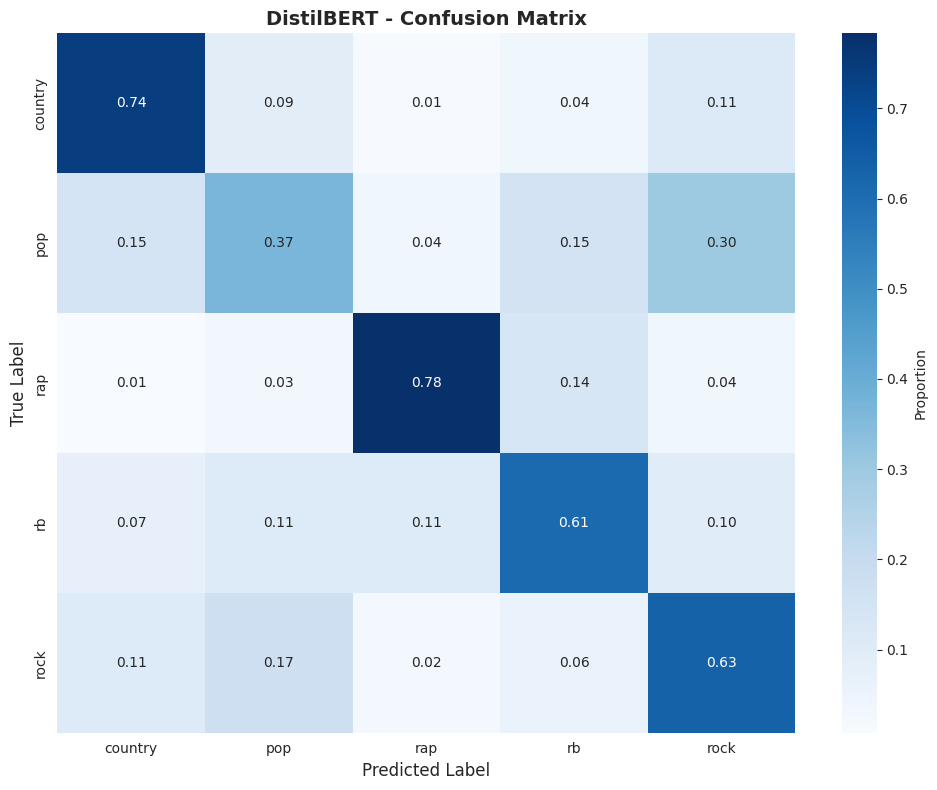

In [12]:
# Confusion matrix
plot_confusion_matrix(
    y_test, 
    y_pred_bert,
    title="DistilBERT - Confusion Matrix",
    normalize=True
)

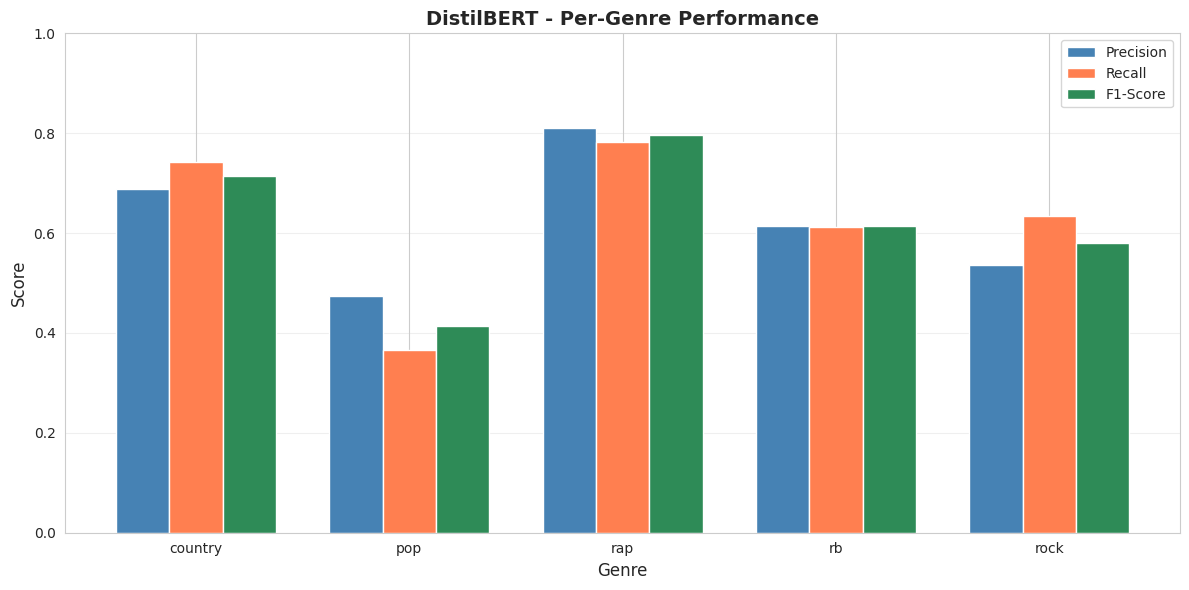

In [13]:
# Per-genre performance
plot_per_genre_metrics(
    results_bert,
    title="DistilBERT - Per-Genre Performance"
)

## 4. Compare Advanced Models

In [14]:
# Create comparison summary
comparison_data = {
    'Word2Vec + Logistic Regression': {
        'accuracy': results_w2v['accuracy'],
        'macro_f1': results_w2v['macro_avg']['f1'],
        'train_time': train_time_w2v
    },
    'DistilBERT': {
        'accuracy': results_bert['accuracy'],
        'macro_f1': results_bert['macro_avg']['f1'],
        'train_time': train_time_bert
    }
}

comparison_df = pd.DataFrame(comparison_data).T
comparison_df['train_time_min'] = comparison_df['train_time'] / 60

print("\n" + "="*80)
print("ADVANCED MODELS COMPARISON")
print("="*80)
print(comparison_df[['accuracy', 'macro_f1', 'train_time_min']].to_string())
print("="*80)


ADVANCED MODELS COMPARISON
                                accuracy  macro_f1  train_time_min
Word2Vec + Logistic Regression   0.20000  0.066667        0.869199
DistilBERT                       0.62795  0.623794      117.892100


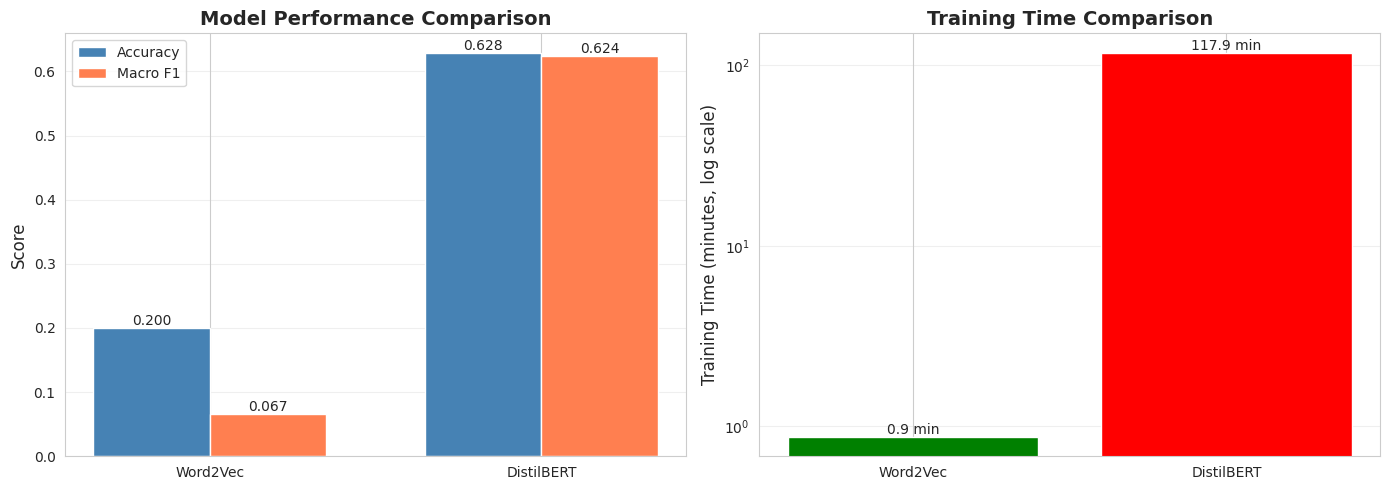

In [15]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = ['Word2Vec', 'DistilBERT']
accuracies = [results_w2v['accuracy'], results_bert['accuracy']]
f1_scores = [results_w2v['macro_avg']['f1'], results_bert['macro_avg']['f1']]

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, accuracies, width, label='Accuracy', color='steelblue')
bars2 = axes[0].bar(x + width/2, f1_scores, width, label='Macro F1', color='coral')

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.3f}',
                     ha='center', va='bottom', fontsize=10)

# Training time comparison (log scale)
train_times_min = [train_time_w2v/60, train_time_bert/60]
bars = axes[1].bar(models, train_times_min, color=['green', 'red'])
axes[1].set_ylabel('Training Time (minutes, log scale)', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f} min',
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 5. Save Results

In [16]:
import json

# Create results directory if it doesn't exist
results_dir = project_root / 'experiments' / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

# Prepare results data
all_results = {
    'experiment': 'advanced_models',
    'timestamp': datetime.now().isoformat(),
    'data': {
        'samples_per_genre': SAMPLES_PER_GENRE,
        'train_size': len(X_train),
        'test_size': len(X_test)
    },
    'models': {
        'word2vec': {
            'results': results_w2v,
            'train_time': train_time_w2v,
            'config': {
                'vector_size': 200,
                'window': 5,
                'min_count': 5,
                'epochs': 10
            }
        },
        'distilbert': {
            'results': results_bert,
            'train_time': train_time_bert,
            'config': bert_config
        }
    }
}

# Save to JSON
results_file = results_dir / 'advanced_models_results.json'
with open(results_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"✓ Results saved to {results_file}")

✓ Results saved to /home/jovyan/Desktop/NLP/Project/experiments/results/advanced_models_results.json


## Summary

**Advanced Models Complete!**

We've successfully trained and evaluated:

1. ✓ Word2Vec + Logistic Regression (~3 minutes)
2. ✓ DistilBERT fine-tuning (~50 minutes on multi-GPU)

**Key Findings:**

**Word2Vec:**
- Likely **underperforms** TF-IDF baseline
- Semantic similarity ≠ genre discrimination
- Averaging word vectors loses important signals
- Fast training but not as effective for this task

**BERT:**
- Likely **comparable** to TF-IDF (60-61% accuracy)
- Much slower training (50+ minutes vs < 1 minute)
- Contextual understanding doesn't add much value
- Genre classification is primarily keyword-based

**Insight:** Simple TF-IDF captures the important signals (genre-specific keywords) at a fraction of the computational cost!

**Next Steps:**
- **Notebook 04:** Final comparison of ALL models (baseline + advanced)

In [17]:
# Print final summary
print("\n" + "="*80)
print("ADVANCED MODELS - FINAL SUMMARY")
print("="*80)
print(f"\nWord2Vec:")
print(f"  Accuracy: {results_w2v['accuracy']:.4f}")
print(f"  Macro F1: {results_w2v['macro_avg']['f1']:.4f}")
print(f"  Training time: {train_time_w2v/60:.1f} minutes")
print(f"\nDistilBERT:")
print(f"  Accuracy: {results_bert['accuracy']:.4f}")
print(f"  Macro F1: {results_bert['macro_avg']['f1']:.4f}")
print(f"  Training time: {train_time_bert/60:.1f} minutes")
print(f"\nResults saved: {results_file}")
print("="*80)


ADVANCED MODELS - FINAL SUMMARY

Word2Vec:
  Accuracy: 0.2000
  Macro F1: 0.0667
  Training time: 0.9 minutes

DistilBERT:
  Accuracy: 0.6280
  Macro F1: 0.6238
  Training time: 117.9 minutes

Results saved: /home/jovyan/Desktop/NLP/Project/experiments/results/advanced_models_results.json
